<a href="https://colab.research.google.com/github/Huzair13/computer_vision_based_image_classification/blob/main/image_classification_using_fasterRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import required libraries
import os
import numpy as np
import pandas as pd
import torch
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
os.chdir('/content/drive/MyDrive/AIML/Labs/CV/Week4/CV_Pothole Detection')

In [ ]:
# unzip the data
!unzip 'train.zip'

Archive:  train.zip
   creating: train/
  inflating: train/labels.csv        
   creating: train/images/
  inflating: train/images/304.jpg    
  inflating: train/images/343.jpg    
  inflating: train/images/672.jpg    
  inflating: train/images/129.jpg    
  inflating: train/images/488.jpg    
  inflating: train/images/427.jpg    
  inflating: train/images/287.jpg    
  inflating: train/images/467.jpg    
  inflating: train/images/121.jpg    
  inflating: train/images/633.jpg    
  inflating: train/images/581.jpg    
  inflating: train/images/649.jpg    
  inflating: train/images/339.jpg    
  inflating: train/images/185.jpg    
  inflating: train/images/527.jpg    
  inflating: train/images/76.jpg     
  inflating: train/images/487.jpg    
  inflating: train/images/295.jpg    
  inflating: train/images/582.jpg    
  inflating: train/images/208.jpg    
  inflating: train/images/671.jpg    
  inflating: train/images/257.jpg    
  inflating: train/images/655.jpg    
  inflating: train/im

In [ ]:
!unzip 'test_niF99zC.zip'

Archive:  test_niF99zC.zip
   creating: test/
   creating: test/images/
  inflating: test/images/900.jpg     
  inflating: test/images/1014.jpg    
  inflating: test/images/1067.jpg    
  inflating: test/images/1000.jpg    
  inflating: test/images/798.jpg     
  inflating: test/images/816.jpg     
  inflating: test/images/1054.jpg    
  inflating: test/images/1129.jpg    
  inflating: test/images/1032.jpg    
  inflating: test/images/860.jpg     
  inflating: test/images/1097.jpg    
  inflating: test/images/1114.jpg    
  inflating: test/images/1047.jpg    
  inflating: test/images/1011.jpg    
  inflating: test/images/995.jpg     
  inflating: test/images/873.jpg     
  inflating: test/images/838.jpg     
  inflating: test/images/867.jpg     
  inflating: test/images/716.jpg     
  inflating: test/images/956.jpg     
  inflating: test/images/1151.jpg    
  inflating: test/images/700.jpg     
  inflating: test/images/1216.jpg    
  inflating: test/images/1070.jpg    
  inflating: tes

**Data Preprocessing**

In [ ]:
# reading csv file
data = pd.read_csv('train/labels.csv')
data.head()

,ImageID,LabelName,XMin,XMax,YMin,YMax
0,1.jpg,pothole,0,131,140,263
1,1.jpg,pothole,168,487,279,449
2,1.jpg,pothole,1,144,34,109
3,2.jpg,pothole,57,952,271,505
4,3.jpg,pothole,225,416,292,439


In [ ]:
data['LabelName'] = data['LabelName'].replace({'pothole': 1})

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# defining required transformations
from torchvision import transforms as TF

transform = TF.Compose([
    TF.Resize((224, 224)),
    TF.ToTensor()
])

In [ ]:
# defining class to load data
class PotHoleDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None,train=True):
        self.root = root
        self.transforms = transforms
        # load all image files
        self.imgs = os.listdir(root)
        if '.ipynb_checkpoints' in self.imgs:
          self.imgs.remove('.ipynb_checkpoints')
        self.train = train

    def __getitem__(self, idx):
        # load images

        img_name = self.imgs[idx]
        img_path = os.path.join(self.root, img_name)
        img = Image.open(img_path)
        if self.train == False:
          if self.transforms is not None:
            img = self.transforms(img)
          return img,img_name
        else:
          h, w = np.array(img).shape[:2]
          num_objs = data[data['ImageID'] == img_name].shape[0]
          boxes = []
          cell_type = []
          for i in range(num_objs):
              xmin = data[data['ImageID'] == img_name]['XMin'].iloc[i]
              xmax = data[data['ImageID'] == img_name]['XMax'].iloc[i]
              ymin = data[data['ImageID'] == img_name]['YMin'].iloc[i]
              ymax = data[data['ImageID'] == img_name]['YMax'].iloc[i]
              target = data[data['ImageID'] == img_name]['LabelName'].iloc[i]
              boxes.append([xmin, ymin, xmax, ymax])
              cell_type.append(target)
          # convert everything into a torch.Tensor
          boxes = torch.as_tensor(boxes, dtype=torch.float32)
          labels = torch.as_tensor(cell_type, dtype=torch.int64)

          target = {}
          target["boxes"] = boxes
          target["labels"] = labels
          #print(boxes)
          if self.transforms is not None:
              img = self.transforms(img)
              boxes[:, 0] = boxes[:, 0] * (224/w)
              boxes[:, 2] = boxes[:, 2] * (224/w)
              boxes[:, 1] = boxes[:, 1] * (224/h)
              boxes[:, 3] = boxes[:, 3] * (224/h)

          return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
dataset = PotHoleDataset('train/images/', transforms=transform)

In [ ]:
## convert list of list to tuple
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
# defining data loader
data_loader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=8, 
    shuffle=False, 
    collate_fn=collate_fn
)

In [ ]:
# testing for one iteration
for batch_x, batch_y in data_loader:
    break

In [ ]:
batch_x[0].shape

torch.Size([3, 224, 224])

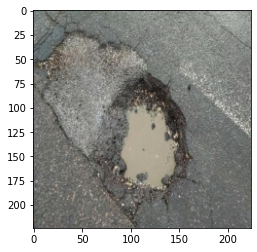

In [ ]:
plt.imshow(np.transpose(batch_x[0], (1, 2, 0)));

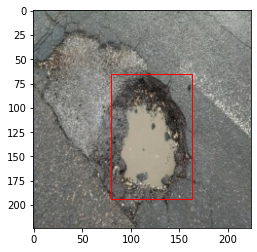

In [ ]:
# plot bounding box
import matplotlib.patches as pc
plt.axes()
plt.imshow(np.transpose(batch_x[0], (1, 2, 0)))
for i in range(len(batch_y[0]['boxes'])):
    bbox = batch_y[0]['boxes'][i]
    x1, y1 = bbox[0], bbox[1]
    x2, y2 = bbox[2], bbox[3]
    if batch_y[0]['labels'][i] == 1:
        color = 'red'

    rectangle = pc.Rectangle((x1,y1), x2-x1, y2-y1, fc='none',ec=color)
    plt.gca().add_patch(rectangle)
plt.show()


**Defining the model**

In [ ]:
# define model
model = fasterrcnn_resnet50_fpn(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [ ]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:

num_classes = 2

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [ ]:

# check model on one image
model.eval()
output = model(batch_x[5].view(1, 3, 224, 224))

In [ ]:
output

[{'boxes': tensor([[1.7720e+02, 1.0944e+02, 1.8177e+02, 1.1340e+02],
          [1.4109e+02, 0.0000e+00, 2.2075e+02, 5.3330e+01],
          [1.9716e+01, 2.0537e-01, 2.1729e+02, 2.3571e+01],
          [1.1162e+02, 0.0000e+00, 2.1532e+02, 1.3691e+02],
          [0.0000e+00, 2.2126e+02, 2.4710e-01, 2.2389e+02],
          [0.0000e+00, 2.2158e+02, 1.0538e+00, 2.2390e+02],
          [1.6500e+02, 0.0000e+00, 2.2093e+02, 8.6414e+01],
          [1.0307e+02, 1.8659e+01, 2.1644e+02, 6.5581e+01],
          [1.2775e+02, 1.3862e+01, 1.8363e+02, 1.0849e+02],
          [1.3017e+02, 0.0000e+00, 2.2082e+02, 2.8512e+01],
          [2.1025e+02, 0.0000e+00, 2.2326e+02, 2.4661e+01],
          [1.9950e+02, 0.0000e+00, 2.2184e+02, 1.2470e+02],
          [4.1537e+01, 4.6638e+01, 9.5967e+01, 1.6765e+02],
          [7.5975e+01, 0.0000e+00, 2.1825e+02, 1.3369e+01],
          [9.5507e+01, 2.6789e+01, 1.8822e+02, 2.1258e+02],
          [4.1233e+01, 1.1289e+01, 1.9489e+02, 1.1394e+02],
          [1.9499e+02, 0.0000e+

In [ ]:
#GPU if avilable
model = model.to(device)

In [ ]:
# define optimization 
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
# set model to train
model.train()

# train model
for epoch in range(5):

    # initialize variables
    epoch_classif_loss = epoch_regress_loss = cnt = 0

    # loop through the data
    for batch_x, batch_y in data_loader:
        # get batch images and targets and transfer them to GPU if available
        batch_x = list(image.to(device) for image in batch_x)
        batch_y = [{k: v.to(device) for k, v in t.items()} for t in batch_y]

        # clear gradients
        optimizer.zero_grad()

        # pass images to model and get loss
        loss_dict = model(batch_x, batch_y)
        losses = sum(loss for loss in loss_dict.values())

        # do a backward pass
        losses.backward()

        # update gradients
        optimizer.step()

        # sum loss and get count
        epoch_classif_loss += loss_dict['loss_classifier'].item()
        epoch_regress_loss += loss_dict['loss_box_reg'].item()
        cnt += 1

    # take average loss for all batches
    epoch_classif_loss /= cnt
    epoch_regress_loss /= cnt
    
    # print loss
    print("Training loss for epoch {} is {} for classification and {} for regression "
        .format(epoch + 1, epoch_classif_loss, epoch_regress_loss)
    )

Training loss for epoch 1 is 0.12128992019330755 for classification and 0.15550201096955468 for regression 
Training loss for epoch 2 is 0.08251792337088024 for classification and 0.12811114437439863 for regression 
Training loss for epoch 3 is 0.06424510266412707 for classification and 0.11255688982851365 for regression 
Training loss for epoch 4 is 0.05793383695623454 for classification and 0.10830784374300172 for regression 
Training loss for epoch 5 is 0.05150423124432564 for classification and 0.09907931549584165 for regression 


**Model Evaluation**

In [ ]:
test_dataset = PotHoleDataset('test/images/', transforms=transform,train=False)

In [ ]:
# defining data loader
data_loader_test = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=8, 
    shuffle=False
)

In [ ]:
my_submission = pd.DataFrame()
model.eval()
for batch_test,names in data_loader_test:
  output = model(batch_test.to(device))
  output = [{k: v.to("cpu") for k, v in t.items()} for t in output]
  temp = pd.DataFrame()
  for i in range(len(output)):
    boxes = output[i]['boxes'].detach().numpy()
    scores = output[i]['scores'].detach().numpy()
    labels = output[i]['labels'].detach().numpy()
    scores = np.expand_dims(scores, axis=1)
    labels = np.expand_dims(labels, axis=1)
    batch_df = pd.DataFrame(np.hstack((boxes,scores,labels)),columns=['XMin','YMin','XMax','YMax','Conf','LabelName'])
    batch_df['ImageID'] = names[i]
    img = cv2.imread('/content/drive/MyDrive/AIML/Labs/CV/Week4/CV_Pothole Detection/test/images/'+names[i])
    h,w = img.shape[:2]
    batch_df['LabelName'] = 'pothole'
    batch_df['XMax'] = batch_df['XMax']/224 * w
    batch_df['XMin'] = batch_df['XMin']/224 * w
    batch_df['YMax'] = batch_df['YMax']/224 * h
    batch_df['YMin'] = batch_df['YMin']/224 * h
    batch_df['XMax'] = batch_df['XMax'].astype(int)
    batch_df['XMin'] = batch_df['XMin'].astype(int)
    batch_df['YMax'] = batch_df['YMax'].astype(int)
    batch_df['YMin'] = batch_df['YMin'].astype(int)
    temp = pd.concat([batch_df,temp])
  my_submission = pd.concat([my_submission,temp])

In [ ]:
my_submission

,XMin,YMin,XMax,YMax,Conf,LabelName,ImageID
0,12,169,268,298,0.988535,pothole,683.jpg
1,13,184,197,261,0.104448,pothole,683.jpg
0,261,233,432,382,0.239274,pothole,688.jpg
0,118,140,811,414,0.995342,pothole,693.jpg
0,96,46,210,133,0.989013,pothole,690.jpg
...,...,...,...,...,...,...,...
1,170,339,268,488,0.556475,pothole,1219.jpg
2,71,184,277,328,0.532059,pothole,1219.jpg
3,47,343,190,511,0.154415,pothole,1219.jpg
0,2024,1098,3008,1607,0.895444,pothole,1210.jpg


In [ ]:
my_submission.to_csv('5_epoch.csv',index=False)